Used for test SHAP value: based on the selected ASVs, most of which are indicators of Non burn soil (which means if it has a higher abundance then it is a not burn soil; these ASV will decrease if it get burned); the only ASV we found will increase if get burned is ASV7.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-03-10 13:33:40.950703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
burn_label = le.fit_transform(burn_label)  
le = LabelEncoder()
un_label = le.fit_transform(un_label)  
le = LabelEncoder()
duration_label = le.fit_transform(duration_label)  

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

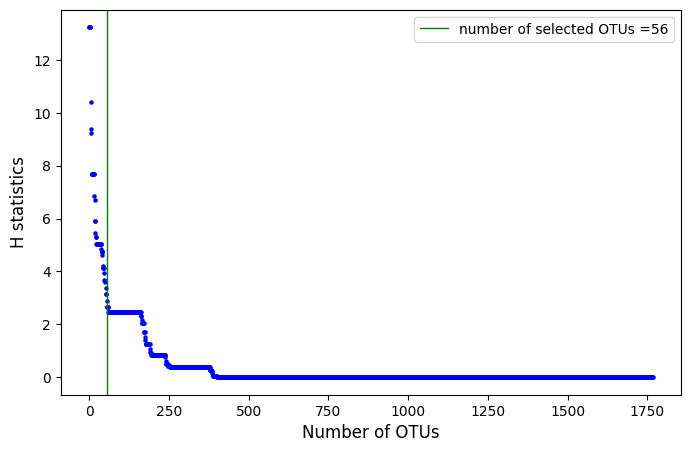

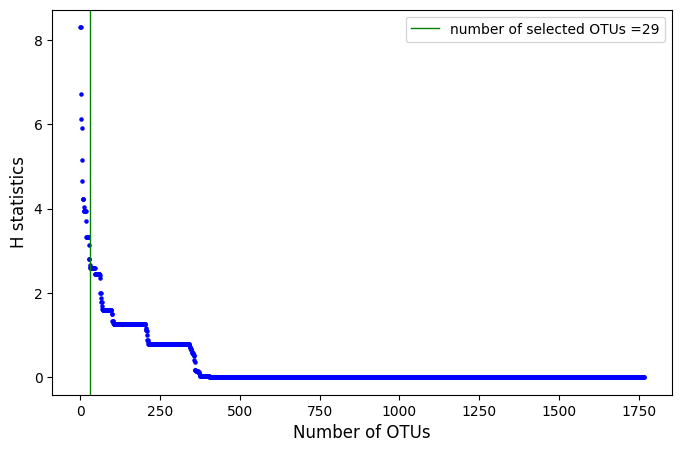

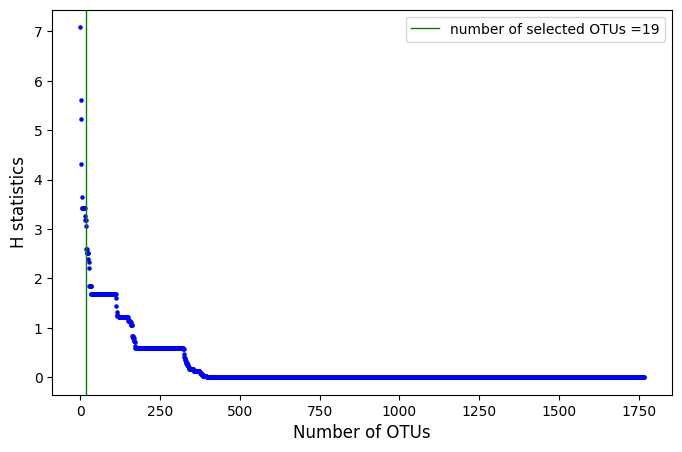

In [7]:
# select the OTUs
taxlabels = ['Burn','urban','duration']

selectedresult_list = []
for y in [burn_label,un_label,duration_label]:
    selectedresult=FS.SelectMicro_fun(df,y)
    selectedresult_list.append(selectedresult)
    
selectedresult.keys()

In [8]:
selectedOTU_index_Lasso_list = []
selectedOTU_index_FS_lasso_list = []

data_subset_list = []

for index, element in enumerate([burn_label,un_label,duration_label]):
    
    selectedresult = selectedresult_list[index]
    
    selectedOTU_index_FS = selectedresult['selected_indices']

    data = selectedresult['relative_abundance_data']
    data_df = pd.DataFrame(data,columns = ASVs)
    X_FS = selectedresult['selected_data']
    X_FS_df =pd.DataFrame(X_FS,columns = selectedresult['selected_columnames'])

    X_lasso_ft,selectedOTU_index_Lasso  = RunML.LassoFS_CV(data,element)
    X_lasso_ft_df = pd.DataFrame(X_lasso_ft,columns = ASVs[selectedOTU_index_Lasso])
    selectedOTU_index_Lasso_list.append(selectedOTU_index_Lasso)

    X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(X_FS,element)
    selectedOTU_index_FS_lasso = selectedOTU_index_FS[xlabel_FS_lasso_ft0]
    X_FS_lasso_ft_df = pd.DataFrame(X_FS_lasso_ft,columns = ASVs[selectedOTU_index_FS_lasso])
    selectedOTU_index_FS_lasso_list.append(selectedOTU_index_FS_lasso)
    
    data_subset = {"AllFeatures":data_df, 
               "SelectMicro": X_FS_df,
               "Lasso_finetune":X_lasso_ft_df,
                "FS_Lassofinetune":X_FS_lasso_ft_df
               #"Random":data
              }
    data_subset_list.append(data_subset)

Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05


In [9]:
for data in data_subset_list:
    print(f'The shape of the full selected dataset is ',np.shape(data['AllFeatures']))
    print(f'The shape of the FS selected dataset is ',np.shape(data['SelectMicro']))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(data['Lasso_finetune']))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(data['FS_Lassofinetune']))
    

The shape of the full selected dataset is  (59, 1768)
The shape of the FS selected dataset is  (59, 56)
The shape of the Lasso_finetune selected dataset is  (59, 14)
The shape of the FS_Lasso_finetune selected dataset is  (59, 15)
The shape of the full selected dataset is  (59, 1768)
The shape of the FS selected dataset is  (59, 29)
The shape of the Lasso_finetune selected dataset is  (59, 11)
The shape of the FS_Lasso_finetune selected dataset is  (59, 14)
The shape of the full selected dataset is  (59, 1768)
The shape of the FS selected dataset is  (59, 19)
The shape of the Lasso_finetune selected dataset is  (59, 7)
The shape of the FS_Lasso_finetune selected dataset is  (59, 12)


### model NB

Burn
AllFeatures


PermutationExplainer explainer: 13it [00:54,  5.47s/it]                         


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

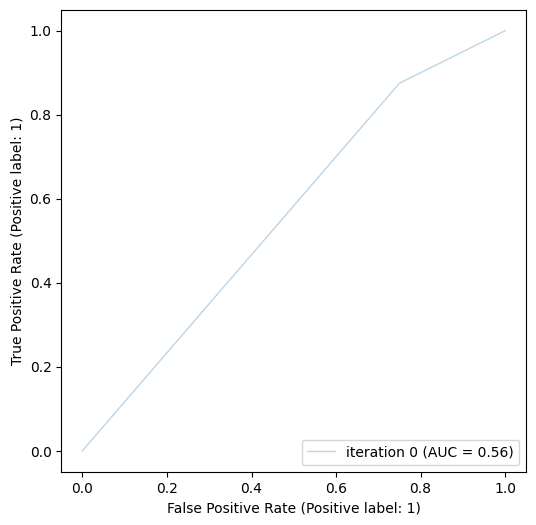

In [10]:
result_rf_list = []
for index, element in enumerate([burn_label,un_label,duration_label]):
    targetLabel=element
    for i, (key, value) in enumerate(data_subset_list[index].items()):
        print(taxlabels[index])
        print(key)
        result_rf_list.append(RunML.NB_model_SCV(value, y=element,plot=True, SMOTE=True,y_base = 1)
)

### 4. Model (default RF) 


In [ ]:
#selected_index[0][1]

In [ ]:
result_rf_list = []
for index, element in enumerate([burn_label,un_label,duration_label]):
    targetLabel=element
    for i, (key, value) in enumerate(data_subset_list[index].items()):
        print(taxlabels[index])
        print(key)
        result_rf_list.append(RunML.RF_model_SCV(value, y=element,plot=True, SMOTE=True,y_base = 1)
)


In [ ]:
len(result_rf_list)# 3 labels *4 datasets

In [ ]:
result_rf_fs = result_rf_list[1]

In [ ]:
print(result_rf_fs['enrich'])

In [ ]:
# check with annual
result_rf_fs3 = result_rf_list[9]

In [ ]:
print(result_rf_fs3['enrich'])

In [ ]:
result_rf_fs.keys()

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

shap.summary_plot(result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'],show=False)
plt.title("FS-Lasso SHAP Summary")



In [ ]:

# Second SHAP summary plot

shap.summary_plot(result_rf_list[2]['SHAP'][:,:,1],result_rf_list[2]['x_true'],show=False)
plt.title("Lasso SHAP Summary")

In [ ]:
# analyzing ASV 191


# make interaction plot.
# when there is no 191, if the value of 216 is low then there is more likelt the soil is burned
# when there is 191 and 216 is none, there is more likely the soil is not burn, and t
shap.dependence_plot('ASV191', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV216")


In [ ]:
# make interaction plot.
# if there is 
shap.dependence_plot('ASV7', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV191")
shap.dependence_plot('ASV8', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV191")
shap.dependence_plot('ASV141', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV191")

In [ ]:
FS_lasso_df = result_rf_list[3]['x_true']

# Get the indices where array1 is not zero
indices = np.where(FS_lasso_df['ASV191'] != 0)

ASV191_df = FS_lasso_df.loc[indices]
SHAP_ASV191 = result_rf_list[3]['SHAP'][:,:,1][indices]

In [ ]:
shap.initjs()# base line is induced
shap.force_plot(0.49, SHAP_ASV191[1,:], ASV191_df.iloc[1])

In [ ]:
indices

In [ ]:
shap.force_plot(0.49, SHAP_ASV191[0,:], ASV191_df.iloc[0])